In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uszipcode import Zipcode, SearchEngine
from geopy.distance import distance

covid = pd.read_csv('../data/california_covid.csv')
earthquake = pd.read_csv('../data/earthquakes_CA.csv')
fire = pd.read_csv('../data/fire_data.csv')

In [2]:
covid.head(2)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,6001.0,Alameda,California,US,2020-10-17 04:24:12,37.646294,-121.892927,22408,439,0,21969.0,"Alameda, California, US",1340.729443,1.959122
1,6003.0,Alpine,California,US,2020-10-17 04:24:12,38.596786,-119.822359,3,0,0,3.0,"Alpine, California, US",265.721878,0.000000


In [3]:
# bringing in county population data as a column to the covid dataframe
population = pd.read_html('https://www.california-demographics.com/counties_by_population')[0]

In [4]:
population.head(2)

,Rank,County,Population
0,1,Los Angeles County,10039107
1,2,San Diego County,3338330


In [5]:
earthquake.head(2)

,Event ID,Name/Epicenter,Date,Lat,Lon,Mag
0,73472891,"10 km (6.25 mi) ESE of Willits, CA",2020-10-19,39.36,-123.25,3.4
1,73472896,"11 km (6.875 mi) ESE of Willits, CA",2020-10-19,39.37,-123.24,3.8


Some fires need updated information for the acres burned. The inciweb has more updated information.

In [6]:
fyre = pd.read_html('https://inciweb.nwcg.gov/accessible-view/')[0]

In [7]:
fyre.head(3)

,Incident,Type,State,Size,Updated
0,North Whizz Dome Fire,Wildfire,"California, USA",200 Acres,11 min. ago
1,Wolf Fire,Wildfire,"California, USA",2040 Acres,30 min. ago
2,Blue Jay Fire,Wildfire,"California, USA",6915 Acres,32 min. ago


In [8]:
fyre = fyre[fyre['State'].str.contains('California')]
fyre = fyre[fyre['Type'] == 'Wildfire']
fyre.reset_index(drop=True, inplace=True)

In [9]:
fyre.head()

,Incident,Type,State,Size,Updated
0,North Whizz Dome Fire,Wildfire,"California, USA",200 Acres,11 min. ago
1,Wolf Fire,Wildfire,"California, USA",2040 Acres,30 min. ago
2,Blue Jay Fire,Wildfire,"California, USA",6915 Acres,32 min. ago
3,Slater/Devil Fires,Wildfire,"California, USA",156832 Acres,1:10 hrs. ago
4,Horse Fire,Wildfire,"California, USA",30 Acres,1:23 hrs. ago


In [10]:
fyre.shape

(29, 5)

In [11]:
fyre[fyre['Incident'] == 'Apple Fire']

,Incident,Type,State,Size,Updated
18,Apple Fire,Wildfire,"California, USA",33424 Acres,10/14/2020


In [12]:
fyre.iloc[16, 3]

'988 Acres'

In [13]:
fyre[fyre['Incident'].str.contains('Red')]

,Incident,Type,State,Size,Updated
7,Red Salmon Complex,Wildfire,"California, USA",143923 Acres,3 hrs. ago


In [14]:
fire.head(3)

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location
0,Apple Fire,False,2020-07-31T18:08:39Z,Riverside,0,0,-116.9617,33.99139,Wildfire,True,False,"off of Oak Glen Road and Apple Tree Lane, Nort..."
1,August Complex (includes Doe Fire),False,2020-08-16T20:37:26Z,"Mendocino, Humboldt, Trinity, Tehama, Glenn, L...",1032209,80,-122.6730,39.77600,Wildfire,True,True,"Mendocino, Humboldt, Trinity, Tehama, Glenn, ..."
2,Red Salmon Complex,False,2020-08-18T09:49:34.58Z,Humboldt,0,0,-123.4070,41.16800,Wildfire,True,False,"near Salmon Mountain, Northeast of Willow Creek"


In [15]:
# subsetting rows that have 0 acres burned in the fire dataframe
fire_0 = fire[fire['AcresBurned'] == 0]
fire_0

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location
0,Apple Fire,False,2020-07-31T18:08:39Z,Riverside,0,0,-116.961700,33.991390,Wildfire,True,False,"off of Oak Glen Road and Apple Tree Lane, Nort..."
2,Red Salmon Complex,False,2020-08-18T09:49:34.58Z,Humboldt,0,0,-123.407000,41.168000,Wildfire,True,False,"near Salmon Mountain, Northeast of Willow Creek"
3,Blue Jay Fire,False,2020-08-18T10:16:11Z,Mariposa,0,0,-119.605810,37.844630,Wildfire,True,False,"Near Tioga Road, North of Yosemite Valley"
4,North Complex Fire,False,2020-08-18T21:21:53Z,"Plumas, Butte",0,0,-121.227180,39.690720,Wildfire,True,False,Flemmings Sheep Camp
5,Dolan Fire,False,2020-08-19T09:23:03Z,Monterey,0,0,-121.602000,36.123000,Wildfire,True,False,"Dolan Rd and Hwy 1, Ventana Wilderness"
7,Slink Fire,False,2020-09-01T12:38:11Z,Mono,0,0,-119.568000,38.568000,Wildfire,True,False,"Slinkard Valley, west of Coleville, California"
8,Rattlesnake Fire,False,2020-09-03T12:36:39Z,Tulare,0,0,-118.448000,36.420000,Wildfire,True,False,The Rattlesnake fire is burning in Sequoia Kin...
9,Moraine Fire,False,2020-08-21T21:00:00Z,Tulare,0,0,-118.557000,36.718000,Wildfire,True,False,"South of Palmer Peak , East of Avalanche Pass ..."
11,El Dorado Fire,False,2020-09-05T12:51:00Z,"San Bernardino, Riverside",0,0,-116.986690,34.080560,Wildfire,True,False,"Oak Glen Rd Road and Potato Canyon Road, West ..."
12,Bobcat Fire,False,2020-09-06T14:42:02Z,Los Angeles,0,0,-117.964838,34.244649,Wildfire,True,False,"Northeast of Cogswell Reservoir, San Gabriel C..."


In [16]:
len(fire_0)

17

In [17]:
# updating the `fire` dataframe with acres burned from inciweb (fyre dataframe)
for fire_name in fire_0['Name']:
    # get the acres where the name matches
    index1 = fyre[fyre['Incident'].str.contains(fire_name.split()[0])].index
    # match only there is at least a match
    if len(list(index1)) > 0:
        acres = fyre.iloc[list(index1)[0], 3].split()[0]
        index2 = fire[fire['Name'] == fire_name].index
        
        fire.iloc[list(index2)[0], 4] = acres  

In [18]:
# check whether it's updated
fire_0 = fire[fire['AcresBurned'] == 0]
fire_0

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location
7,Slink Fire,False,2020-09-01T12:38:11Z,Mono,0,0,-119.568000,38.568000,Wildfire,True,False,"Slinkard Valley, west of Coleville, California"
12,Bobcat Fire,False,2020-09-06T14:42:02Z,Los Angeles,0,0,-117.964838,34.244649,Wildfire,True,False,"Northeast of Cogswell Reservoir, San Gabriel C..."
165,Beach Fire,True,2020-08-17T12:31:38Z,Mono,0,0,-119.010655,37.919382,Wildfire,False,False,"Hwy 120 and Forest Road 1N23, south of Mono Lake"
179,W-5 Cold Springs,True,2020-08-23T08:24:24Z,Lassen,0,0,-120.281389,41.028611,Wildfire,False,False,"Cold Spring Road, West of Cold Spring Mountain"


In [19]:
fire[fire['PercentContained'] == 0]

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location
0,Apple Fire,False,2020-07-31T18:08:39Z,Riverside,33424,0,-116.961700,33.991390,Wildfire,True,False,"off of Oak Glen Road and Apple Tree Lane, Nort..."
2,Red Salmon Complex,False,2020-08-18T09:49:34.58Z,Humboldt,143923,0,-123.407000,41.168000,Wildfire,True,False,"near Salmon Mountain, Northeast of Willow Creek"
3,Blue Jay Fire,False,2020-08-18T10:16:11Z,Mariposa,6915,0,-119.605810,37.844630,Wildfire,True,False,"Near Tioga Road, North of Yosemite Valley"
4,North Complex Fire,False,2020-08-18T21:21:53Z,"Plumas, Butte",200,0,-121.227180,39.690720,Wildfire,True,False,Flemmings Sheep Camp
5,Dolan Fire,False,2020-08-19T09:23:03Z,Monterey,124924,0,-121.602000,36.123000,Wildfire,True,False,"Dolan Rd and Hwy 1, Ventana Wilderness"
7,Slink Fire,False,2020-09-01T12:38:11Z,Mono,0,0,-119.568000,38.568000,Wildfire,True,False,"Slinkard Valley, west of Coleville, California"
8,Rattlesnake Fire,False,2020-09-03T12:36:39Z,Tulare,7241,0,-118.448000,36.420000,Wildfire,True,False,The Rattlesnake fire is burning in Sequoia Kin...
9,Moraine Fire,False,2020-08-21T21:00:00Z,Tulare,988,0,-118.557000,36.718000,Wildfire,True,False,"South of Palmer Peak , East of Avalanche Pass ..."
11,El Dorado Fire,False,2020-09-05T12:51:00Z,"San Bernardino, Riverside",22744,0,-116.986690,34.080560,Wildfire,True,False,"Oak Glen Rd Road and Potato Canyon Road, West ..."
12,Bobcat Fire,False,2020-09-06T14:42:02Z,Los Angeles,0,0,-117.964838,34.244649,Wildfire,True,False,"Northeast of Cogswell Reservoir, San Gabriel C..."


There are still fires that don't have the updated burned acres here. I can only find it through individual searches on inciweb. I will update the percent containment as well.
The links are:   
[Slink Fire](https://inciweb.nwcg.gov/incident/article/7105/55963/)   
[Bobcat Fire](https://inciweb.nwcg.gov/incident/7152/)   
[Beach Fire](https://inciweb.nwcg.gov/incident/6987/)   
[W-5 Cold Springs](https://inciweb.nwcg.gov/incident/7010/)

For percent containment:  
[Apple Fire, Red Salmon Complex, North Complex Fire, Dolan Fire, El Dorado Fire, Slater Fire (includes Devil Fire), Fork Fire, ](https://www.sfchronicle.com/projects/california-fire-map/)  
[Blue Jay Fire](https://inciweb.nwcg.gov/incident/6888/)  
[Rattlesnake Fire](https://inciweb.nwcg.gov/incident/7131/)  
[Moraine Fire](https://inciweb.nwcg.gov/incident/7089/)  
[Bullfrog Fire](https://inciweb.nwcg.gov/incident/7191/)  
[Wolf Fire](https://inciweb.nwcg.gov/incident/7134/)
[Hobo Fire](https://inciweb.nwcg.gov/incident/7126/)

In [20]:
fire_update = {'Slink Fire': [26759, 90], 'Bobcat Fire ': [115796, 92], 
               'Beach Fire ': [3780, 100], 'W-5 Cold Springs': [84817, 100]}
for key, value in fire_update.items():
    index = list(fire[fire['Name'] == key].index)
    fire.iloc[index[0], 4] = value[0]
    fire.iloc[index[0], 5] = value[1]
    
containment_update = {'Apple Fire': 95, 'Red Salmon Complex': 75, 'Blue Jay Fire': 50, 'North Complex Fire': 95,
                     'Dolan Fire': 98, 'Rattlesnake Fire': 40, 'Moraine Fire': 70, 'El Dorado Fire': 95,
                     'Slater Fire (includes Devil Fire)': 85, 'Fork Fire': 85, 'Bullfrog Fire': 60, 
                     'Wolf Fire': 40, 'Hobo Fire ': 100}

for key, value in containment_update.items():
    index = list(fire[fire['Name'] == key].index)
    fire.iloc[index[0], 5] = value


In [21]:
# verify
fire[fire['AcresBurned'] == 0]

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location


In [22]:
# verify
fire[fire['PercentContained'] == 0]

,Name,Final,Started,County,AcresBurned,PercentContained,Longitude,Latitude,Type,IsActive,CalFireIncident,Location


In [23]:
fire.astype({'AcresBurned': 'int64'}).dtypes

Name                 object
Final                  bool
Started              object
County               object
AcresBurned           int64
PercentContained      int64
Longitude           float64
Latitude            float64
Type                 object
IsActive               bool
CalFireIncident        bool
Location             object
dtype: object

In [24]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              202 non-null    object 
 1   Final             202 non-null    bool   
 2   Started           202 non-null    object 
 3   County            202 non-null    object 
 4   AcresBurned       202 non-null    object 
 5   PercentContained  202 non-null    int64  
 6   Longitude         202 non-null    float64
 7   Latitude          202 non-null    float64
 8   Type              202 non-null    object 
 9   IsActive          202 non-null    bool   
 10  CalFireIncident   202 non-null    bool   
 11  Location          202 non-null    object 
dtypes: bool(3), float64(2), int64(1), object(6)
memory usage: 14.9+ KB


In [25]:
# for some reason it's not letting the column to convert to int type, so I'm going to strip 
# any possible white spaces and convert back to int
fire['AcresBurned'] = fire['AcresBurned'].apply(lambda x: int(str(x).split()[0]))

In [26]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              202 non-null    object 
 1   Final             202 non-null    bool   
 2   Started           202 non-null    object 
 3   County            202 non-null    object 
 4   AcresBurned       202 non-null    int64  
 5   PercentContained  202 non-null    int64  
 6   Longitude         202 non-null    float64
 7   Latitude          202 non-null    float64
 8   Type              202 non-null    object 
 9   IsActive          202 non-null    bool   
 10  CalFireIncident   202 non-null    bool   
 11  Location          202 non-null    object 
dtypes: bool(3), float64(2), int64(2), object(5)
memory usage: 14.9+ KB


In [27]:
# This is fraction of california that has burned this year so far.
california_total_area = 99813760 # in acres; result from wikipedia (excludes water)
burned_area_2020 = sum(fire['AcresBurned'])
fraction_of_area_burned_2020 = burned_area_2020 / california_total_area
fraction_of_area_burned_2020

0.035565467125975414

In [28]:
burned_area_2020 # total acres burned

3549923

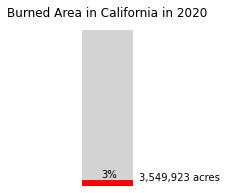

In [29]:
barh1 = california_total_area/california_total_area
barh2 = burned_area_2020/california_total_area

r = np.arange(barh1)

plt.figure(figsize=(1, 3))
plt.box(False)
plt.bar(r, california_total_area/california_total_area, color='lightgrey')
plt.bar(r, burned_area_2020/california_total_area, color='red')
plt.title('Burned Area in California in 2020')

# plt.text(x=r-0.6, y=barh1+0.01, s=str(california_total_area)+ ' acres')
plt.text(x=r+0.5, y=barh2, s='3,549,923 acres')
plt.text(x=r-0.1, y=barh2+0.02, s=str(int(fraction_of_area_burned_2020 *100))+'%')

plt.yticks([])
plt.xticks([])

plt.savefig('../figures/area_burned', bbox_inches='tight');

In [30]:
# Number of fires this year
len(fire)

202

In [31]:
# Number of active fires as of October 17th
fire['IsActive'].sum()

19

In [32]:
covid.shape

(58, 14)

In [33]:
population.shape

(59, 3)

In [34]:
# the last row is not a county so drop it
population = population[:-1]

In [35]:
# the last row is not a county so drop it
population = population[population['County'].str.contains('County')]
# change `Population` data to int
population['Population'] = population['Population'].apply(lambda x: int(str(x).split()[0]))
population.dtypes

Rank          object
County        object
Population     int64
dtype: object

In [36]:
# fix county names so they don't contain 'County'
population['county'] = population['County'].apply(lambda x: ' '.join(x.split()[:-1]))

In [37]:
# drop 'Rank' and 'County' columns from population dataframe
population.drop(columns=['Rank', 'County'], inplace=True)

In [38]:
earthquake.shape

(200, 6)

In [39]:
earthquake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Event ID        200 non-null    object 
 1   Name/Epicenter  200 non-null    object 
 2   Date            200 non-null    object 
 3   Lat             200 non-null    float64
 4   Lon             200 non-null    float64
 5   Mag             200 non-null    float64
dtypes: float64(3), object(3)
memory usage: 9.5+ KB


In [40]:
# number of earthquakes
len(earthquake)

200

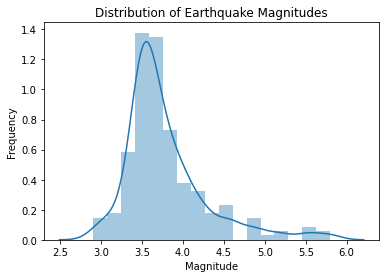

In [46]:
sns.distplot(earthquake['Mag'])
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Earthquake Magnitudes')
plt.savefig('../figures/magnitude_distribution', bbox_inches='tight');

In [35]:
fire['Type'].value_counts()

Wildfire    202
Name: Type, dtype: int64

In [36]:
# drop `Type` column because they are all wildfires
fire.drop(columns = ['Type'], inplace = True)

The goal here is to merge dataframes based on county column as a common key. Covid data is clean and ready to go. Some fires extend to multiple counties. We are going to base our analysis on the county level, so we need to preserve the fire information for each county. Here, we are going to separate the county to individual counties while copying the fire data where the fire spans to multiple counties.

In [37]:
# first change the `County` column from str to a list
fire['County'] = fire['County'].apply(lambda x: x.split(', '))

In [38]:
# modified from https://stackoverflow.com/questions/24029659/python-pandas-replicate-rows-in-dataframe
# making copies of the rows with more than one county listed. The number of copies correspond to the number of counties
reps = [len(county) if  len(county) > 1 else 1 for county in fire['County']]
fire = fire.loc[np.repeat(fire.index.values, reps)]

In [39]:
# reset index 
fire.reset_index(inplace=True, drop=True)

In [40]:
# reassign single counties to the `County` column

# index counter and an empty counties list
index = 0
counties = []

# loop to have an index track to not go out of index range
for indexer in range(len(fire)):
    while index <= indexer:
        
        # if there is only a single county name, append that county name to the list
        if len(fire.iloc[index, 3]) == 1:
            counties.append(fire.iloc[index, 3][0])
            index += 1
            
        # if there is more than one single county name, append each county name to the list
        else:
            for i in range(0, len(fire.iloc[index, 3])):
                # append each indiviual county name of the multi-county list
                counties.append(fire.iloc[index, 3][i])
            # set the index, so that it goes to the next 'unique' item
            index += len(fire.iloc[index, 3])

# reassign `County` column to this new list
fire['County'] = counties

The earthquake dataset does not include county names, so we are making a new column with the county names assigned from latitude and longitude using the python `uszipcode` library.

In [41]:
# make a function to retrive the county name from lat and long 
def county_name(x):
    '''Takes in latitude and longitude (as a literable) and returns the closest county name for the given coordinates'''
    lat, long = x
    search = SearchEngine()
    result = search.by_coordinates(lat, long, radius=100)
    # get the county name
    try:
        county = result[0].county
        
        # this is in 'XXXX County', so fix the format so that it's only the county name without 'County' at the end
        county = county.split()
        
        # get everything but the last item (which is 'County')
        county = county[:-1]
        
        # return a string
        return ' '.join(county)
        
    except:
        print(f'Something went wrong. Check your coordinates: {x}')    
  

In [42]:
counties = earthquake[['Lat', 'Lon']].apply(county_name, axis=1)

In [43]:
# add a county column
earthquake['county'] = counties

In [44]:
# making dictionaries to change column names before merging

covid_cols = {
    'FIPS': 'fips',
    'Admin2': 'county',
    'Province_State': 'province_state',
    'Country_Region': 'country',
    'Last_Update': 'covid_last_update',
    'Lat': 'county_latitude',
    'Long_': 'county_longitudue',
    'Confirmed': 'covid_confirmed',
    'Deaths': 'covid_death',
    'Recovered': 'covid_recovered',
    'Active': 'covid_active',
    'Combined_Key': 'combined_key',
    'Incidence_Rate': 'covid_indidence_rate',
    'Case-Fatality_Ratio': 'covid_case_fatality_ratio'
}

population_col = {'Population': 'county_population'}

earthquake_cols = {
    'Event ID': 'earthquake_id',
    'Name/Epicenter': 'eipicenter',
    'Date': 'earthquake_date',
    'Lat': 'earthquake_latidute',
    'Lon': 'earthquake_longitude',
    'Mag': 'magnitude'
}

fire_cols = {
    'Name': 'fire_name',
    'Final': 'fire_is_final',
    'Started': 'fire_started',
    'County': 'county',
    'AcresBurned': 'acres_burned',
    'PercentContained': 'fire_percent_contained',
    'Longitude': 'fire_longitude',
    'Latitude': 'fire_latitude',
    'IsActive': 'fire_is_active',
    'CalFireIncident': 'is_calfireincident',
    'Location': 'fire_location'
}

In [45]:
# rename all columns before merging
covid.rename(columns=covid_cols, inplace=True)

population.rename(columns=population_col, inplace=True)

earthquake.rename(columns=earthquake_cols, inplace=True)

fire.rename(columns=fire_cols, inplace=True)

Merge all three dataframes using `county` as the common key. In order to keep all information, we are using outer merge.

In [46]:
# first merge the population data to covid data. this will be done as left join
covid = pd.merge(covid, population, on='county', how='left')

# merge covid and earthquake data
covid_earthquake = pd.merge(covid, earthquake, how='outer', on='county')

# merge fire data to the above
all_3 = pd.merge(covid_earthquake, fire, how='outer', on='county')

# write to file
all_3.to_csv('../data/covid_fire_earthquake.csv', index=False)

#### Summarize the all data on county-level

In [47]:
# add per capitat number for covid
covid['covid_death_per_capita'] = covid['covid_death'] / covid['county_population']
covid['covid_confirmed_per_capita'] = covid['covid_confirmed'] / covid['county_population']
covid['covid_active_cases_per_capita'] = covid['covid_active'] / covid['county_population']

Here we want some county-level information on fires.

In [48]:
# find how many fires per county in 2020
fires_per_county = fire.groupby('county')['fire_name'].size().to_frame()

# add fire per county data to covid
covid['fires_per_county_in_2020'] = covid.merge(fires_per_county, on='county', right_index=True)['fire_name']

# fill NaNs with 0 since those are the ones that had no fires this year
covid.fillna(0, inplace=True)

In [49]:
# classify fires based on burned acres
def class_fire(acres_burned):
    if (acres_burned > 0) and (acres_burned <= 200_000):
        return 1
    elif acres_burned <= 400_000:
        return 2
    elif acres_burned <= 600_000:
        return 2
    elif acres_burned <= 800_000:
        return 2
    elif acres_burned <= 1_000_000:
        return 5
    else:
        return 6

# make a new column for fire classification
fire['fire_class'] = fire['acres_burned'].apply(class_fire)

In [50]:
# add number of active fires per county to the covid data
# find how many fires per county in 2020
active_fires = fire[fire['fire_is_active']].groupby('county').size().to_frame()

# add fire per county data to covid
covid['active_fires_per_county'] = covid.merge(active_fires, on='county', right_index=True)[0]

# fill NaNs with 0 since those are the ones that had no fires this year
covid.fillna(0, inplace=True)

In [51]:
# change`fire_is_active` column to True = 1 and False =0
fire['fire_is_active'] = np.where(fire['fire_is_active'] == True, 1, 0)

We are going to give a score for fires. In this case, the score is based on the combination of number of fires, whether they are active or not, and the magnitude of the fire as classified above based on acres burned.
$$ \text{fire score} = \text{number of fires} \times \text{active fire} + \text{number of fires} \times \text{fire class} $$



In [52]:
# getting (number of fires) × (fire class) 
fire_class_score = fire.groupby('county')['fire_class'].sum().to_frame()
# getting (number of fires) × (active fire)
fire_active_score = fire.groupby('county')['fire_is_active'].sum().to_frame()
# calculate the scores
fire_score = fire_class_score.merge(fire_active_score, on='county')
fire_score['score'] = fire_score['fire_class'] + fire_score['fire_is_active']

# get rid of unnecessary columns before merging
fire_score.drop(columns=['fire_class', 'fire_is_active'], inplace=True)

# add fire per county data to covid
covid['fire_score'] = covid.merge(fire_score, on='county', right_index=True)['score']

# fill NaNs with 0 since those are the ones that had no earthquakes this year
covid.fillna(0, inplace=True)

We also want county-level data on earthquakes

In [53]:
# find how many earthquakes per county in 2020
earthquakes_per_county = earthquake.groupby('county')['earthquake_id'].size().to_frame()

# add fire per county data to covid
covid['earthquakes_per_county_in_2020'] = covid.merge(earthquakes_per_county, on='county', right_index=True)['earthquake_id']

# fill NaNs with 0 since those are the ones that had no earthquakes this year
covid.fillna(0, inplace=True)

We are going to classify earthquakes based on on their magnitude. 

In [54]:
def class_earthquake(magnitude):
    if magnitude >= 6:
        return 3 # Strong category
    
    elif magnitude >= 5:
        return 2 # Moderate category
    
    else:
        return 1 # Light category

In [55]:
# make a column with earthquake classifications
earthquake['earthquake_class'] = earthquake['magnitude'].apply(class_earthquake)

We want to give some metric of comparison for each county. For this, we are using the classification based on the magnitude and the number of earthquakes. For example, a county that has 2 earthquake in the category of 1 (lighht) would get a score of 2 (1 * 2) or a county with 3 earthquake in the category of 1 and 1 in the category of 2 (moderate) would get a score of 5 (3 * 1 + 1 * 2).

In [56]:
earthquake_score = earthquake.groupby('county')['earthquake_class'].sum().to_frame()

# add fire per county data to covid
covid['earthquakes_score'] = covid.merge(earthquake_score, on='county', right_index=True)['earthquake_class']

# fill NaNs with 0 since those are the ones that had no earthquakes this year
covid.fillna(0, inplace=True)

In [ ]:
covid.drop(columns=['country', 'combined_key'], inplace = True)

In [ ]:
pd.set_option('display.max_columns', 500)
covid.head(2)

In [ ]:
# change dtypes to appropriate ones
covid = covid.astype({'fires_per_county_in_2020': 'int64',
                      'active_fires_per_county': 'int64',
                      'fire_score': 'int64',
                      'earthquakes_per_county_in_2020': 'int64',
                      'earthquakes_score': 'int64'})

In [ ]:
covid.info()

In [ ]:
# write to file
#covid.to_csv('../data/covid_fire_earthquake_summary.csv', index=False)